# Compute Architecure - Assessment
**Course**: TU 2025 25-26: 8645 -- COMPUTER INFRASTRUCTURE  
**Lecturer**: Ian McLauglin  
**Author**: Clyde Watts  








### Imports

yfinance - financial ticker data from yahoo  - [yfinance](https://github.com/ranaroussi/yfinance)
datetime - pythons inbuild date time
logging - python logging
os - operating system functions
glob - file selector

In [327]:

import logging
from datetime import datetime, timedelta
import os
import pathlib as Path
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf

##  Initialisation

In [328]:
# init logging
logging.basicConfig(level=logging.INFO)

In [329]:
# Delete all CSV files in the data directory
data_path = "./data/"
files = glob.glob(os.path.join(data_path, "*.csv"))
for f in files:
    print(f"Deleting file: {f}")
    os.remove(f)

Deleting file: ./data\20251102_150405.csv


__Helper Function__

I wanted to have ticks and x like some copilots generate
This was generated by using the prompt

How do a print a status tick for success and x for failure

## Problem 1: Data from yfinance

Using the [yfinance](https://github.com/ranaroussi/yfinance) Python package, write a function called `get_data()` that downloads all hourly data for the previous five days for the five FAANG stocks:

- Facebook (META)
- Apple (AAPL)
- Amazon (AMZN)
- Netflix (NFLX)
- Google (GOOG)

The function should save the data into a folder called `data` in the root of your repository using a filename with the format `YYYYMMDD-HHmmss.csv` where `YYYYMMDD` is the four-digit year (e.g. 2025), followed by the two-digit month (e.g. `09` for September), followed by the two digit day, and `HHmmss` is hour, minutes, seconds.
Create the `data` folder if you don't already have one.

## Problem 1: Requirements ##

### Extract ###

1.  Extract from yfinance data the stock data for META,AAPL,AMZN,NFLX,GOOG
2.  For 5 complete previous days trading , we need to take into account that NASDAQ trades from Monday to Friday. If we go back 7 days we will always ignore weekends
3.  File format will YYYYMMDD-HHmmss.csv where YYYY - is 4 digit year , MM month 01-12 , DD - is 01-31. HH - hours , 24 our clock , mm - minutes 00-59 , seconds 00-59.
4.  Grain - Hour

Column
Date , <ticket> ( Open,High,Low,Close,Volume) ....
ticket is META , AAPL , AMZN , NFLX or GOOG
Open - open price
Close - close price
High - High pricr
Low - Low price
Volumn - Volume in period

The data frame return has an index on the date , and is a multilevel index. Level one is the ticket , and the second level is the metric - that is open , close , high , low prices and volume 
 

Todo:

1. Take Into account non-trading days as well as weekends - considered over engineering
1. Add a time column with EST instead of UCT.

__Function : get_data__

This downloads the latest data for a number of listed stock companies using yfinance module and writes to CSV file. 

In [330]:
# prototype for extracting stock data
tickers = ["META", "AAPL", "AMZN", "NFLX", "GOOG"]
def get_data(tickers = tickers,start_date=None, end_date=None,interval="1h",data_path="./data/"):
    """
    Function to get stock data from yfinance

    Parameters:
    tickers (list): List of stock tickers to download data for
    start_date (str): Start date for data in format "YYYY-MM-DD". If None, defaults to 6 days ago.
    end_date (str): End date for data in format "YYYY-MM-DD". If None, defaults to yesterday.
    interval (str): Data interval. Default is "1h".
    data_path (str): Path to save the data. Default is "./data/".
    Returns:
       return_code : 0 for success, -1 for failure
       return_message : message indicating success or failure
       file_name (str): Name of the file where data is saved
    """
    return_code = 0
    return_message = "Success"
    file_name = None
    if start_date is None:
        # Variation of the fence posting to get last 7 days of data
        start_date = (datetime.now() - timedelta(days=7)).strftime("%Y-%m-%d")
        # create file name based on current date and time
        file_name = f"{data_path}{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    else:
        # convert start_date to datetime object
        start_date_time = datetime.strptime(start_date, "%Y-%m-%d")
        # create file name based on start time and 23:59:59 of end date
        start_date_str = start_date_time.strftime("%Y%m%d") + "_235959"
        file_name = f"{data_path}{start_date_str}.csv"
    # if end_date is None , set to today - 0 days this means yesterday's data inclusive
    if end_date is None:
        end_date = (datetime.now() - timedelta(days=0)).strftime("%Y-%m-%d")
    else: # convert end_date to datetime object
        end_date_time = datetime.strptime(end_date, "%Y-%m-%d")
        # add 1 day to end_date to make it inclusive
        end_date = (end_date_time + timedelta(days=1)).strftime("%Y-%m-%d")
    # check if directory exists
    if not os.path.exists(data_path):
        logging.info(f"Creating directory: {data_path}")
        try:
            os.makedirs(data_path)
        except Exception as e:
            logging.error(f"Error creating directory: {e}")
            return_code = -1
            return_message = f"Error creating directory: {e}"
            return return_code, return_message, None
    # if file exists then delete it
    if os.path.exists(file_name):
        logging.info(f"Deleting existing file: {file_name}")
        try:
            os.remove(file_name)
        except Exception as e:
            logging.error(f"Error deleting file: {e}")
            return_code = -1
            return_message = f"Error deleting file: {e}"
            return return_code, return_message, None
    logging.info(f"Start Date: {start_date}, End Date: {end_date}")
    try:
        df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
    except Exception as e:
        logging.error(f"Error downloading data: {e}")
        return_code = -1
        return_message = f"Error downloading data: {e}"
        return return_code, return_message, None
    # Save the data to a CSV file
    df_data.to_csv(file_name)
    return return_code, return_message, file_name
   



In [331]:
print("Starting data download...")
return_code, return_message, file_name = get_data(tickers=tickers)
print(f"Return Code: {return_code}, Message: {return_message}, File: {file_name}")
df_data = get_data(tickers=tickers) 

INFO:root:Start Date: 2025-10-26, End Date: 2025-11-02
C:\Users\cw171001\AppData\Local\Temp\ipykernel_2576\3298150898.py:61: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed
INFO:root:Deleting existing file: ./data/20251102_180146.csv
INFO:root:Start Date: 2025-10-26, End Date: 2025-11-02
C:\Users\cw171001\AppData\Local\Temp\ipykernel_2576\3298150898.py:61: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
[                       0%                       ]

Starting data download...
Return Code: 0, Message: Success, File: ./data/20251102_180146.csv


[*********************100%***********************]  5 of 5 completed


## Problem 2: Plotting Data

Write a function called `plot_data()` that opens the latest data file in the `data` folder and, on one plot, plots the `Close` prices for each of the five stocks.
The plot should include axis labels, a legend, and the date as a title.
The function should save the plot into a `plots` folder in the root of your repository using a filename in the format `YYYYMMDD-HHmmss.png`.
Create the `plots` folder if you don't already have one.

Requirements

1. Glob the data folder for YYYYMMDD_hhmmss.csv files. 
    1. We will glob the files looking for the pattern 20*.*csv
    1.

References

https://docs.python.org/3/library/glob.html


Clear Down Data before test

__Function : get_the_latest_file__

This scans directory ./data ( parameter ) using a pattern 20....csv to get the latest file and returns the file name

In [332]:
#------------------------------------------------------------------------------
# Function to get the latest file from a directory
#------------------------------------------------------------------------------

def get_latest_file(data_path="./data/"):
    """
    Returns the path to the latest data file in the specified directory.

    Args:
        data_path (str): The path to the directory containing the data files.

        tuple: (return_code, return_message, latest_file) where latest_file is the path to the latest data file, or None if no files are found.
        str: The path to the latest data file, or None if no files are found.
    """
    return_code = 0
    return_message = "Success"
    latest_file = None

    logging.info(f"Getting the latest file from {data_path}")
    # File pattern
    file_pattern = "20[0-9][0-9][0-1][0-9][0-3][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9].csv"
    # Add path to file pattern
    file_pattern = os.path.join(data_path, file_pattern)
    # glob searches directories for files based on a pattern
    try:
        list_of_files = glob.glob(file_pattern)
    except Exception as e:
        logging.error(f"Error occurred while searching for files: {e}")
        return_code=-1
        return_message=f"Error occurred while searching for files: {e}"
        return return_code, return_message, None
    if not list_of_files:
        logging.warning(f"No files found in {data_path} matching pattern {file_pattern}")
        return_code = -1
        return_message = f"No files found in {data_path} matching pattern {file_pattern}"
        return return_code, return_message, None
    # find the latest file based on creation time
    #    max parameters - list and function which gets "value" associated with each item in the list
    #    this gets the "youngest" file based on creation time 
    #    not necessarily the latest date in the file name - design decision 
    #    the premise is that the latest file created is the one we want to use
    latest_file = max(list_of_files, key=os.path.getctime)
    logging.info(f"Latest file: {latest_file}")
    return return_code, return_message, latest_file

### Load data from 

In [333]:
return_code, return_message, file_name = get_latest_file()
print(f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {file_name}")
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {file_name}", return_message)
# now get png file name from csv file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(file_name, "./plots/")
print(f"PNG file path: {png_file_path}")
print_status(return_code, f"PNG file path retrieval - Return Code: {return_code}, Message: {return_message}, File: {png_file_path}", return_message)


INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251102_180146.csv


Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251102_180146.csv
✓ Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251102_180146.csv: SUCCESS
  Message: Success
PNG file path: plots\20251102_180146.png
✓ PNG file path retrieval - Return Code: 0, Message: Success, File: plots\20251102_180146.png: SUCCESS
  Message: Success


__Function : load_file_into_dataframe__

This loads the file name into data frame

In [334]:
def load_file_into_dataframe(file):
    """load_file_into_dataframe

    Args:
        file (str): The path to the data file.

    Returns:
        tuple: (return_code, return_message, df) where:
            return_code (int): 0 for success, -1 for failure
            return_message (str): Success or error message
            df (pd.DataFrame): The data as a pandas DataFrame with multi-level columns
    """
    return_code = 0
    return_message = "Success"
    df = None
    
    # Check if file name is provided
    if file is None:
        logging.error("No file provided to load into dataframe.")
        return_code = -1
        return_message = "No file provided to load into dataframe."
        return return_code, return_message, None
    
    # Check if file exists
    if not os.path.exists(file):
        logging.error(f"File does not exist: {file}")
        return_code = -1
        return_message = f"File does not exist: {file}"
        return return_code, return_message, None
    
    # Load the CSV file into a DataFrame with multi-level columns
    try:
        df = pd.read_csv(file, header=[0,1], index_col=0, parse_dates=True)
        logging.info(f"Successfully loaded data from {file}. Shape: {df.shape}")
    except Exception as e:
        logging.error(f"Error loading file {file}: {e}")
        return_code = -1
        return_message = f"Error loading file {file}: {e}"
        return return_code, return_message, None
    
    return return_code, return_message, df



In [335]:
print("Loading data from the latest file...")
return_code, return_message, latest_file = get_latest_file()
full_file_name = os.path.abspath(latest_file)
print(f"Loading data from file: {full_file_name}")
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

return_code, return_message, df = load_file_into_dataframe(latest_file)
print_status(return_code, f"File load - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

print(df.shape)
# convert csv file name to png file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(latest_file, "./plots/")
print(f"PNG file path: {png_file_path}")

INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251102_180146.csv
INFO:root:Successfully loaded data from ./data\20251102_180146.csv. Shape: (35, 25)


Loading data from the latest file...
Loading data from file: c:\Users\cw171001\OneDrive - Teradata\Documents\GitHub\PFDA_computer_architecture\data\20251102_180146.csv
✓ Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251102_180146.csv: SUCCESS
  Message: Success
✓ File load - Return Code: 0, Message: Success, File: ./data\20251102_180146.csv: SUCCESS
  Message: Success
(35, 25)
PNG file path: plots\20251102_180146.png


### Investigate Data Frame

Have a look at the dataframe and see it's structure. 

https://ranaroussi.github.io/yfinance/reference/api/yfinance.download.html#yfinance.download

The index is DatetimeIndex - that is the timestamp of the price.
The data appears Company/Ticker - and then metrics - open,high,low,close,volume



In [336]:
# Have a look at the index and columns
print(" Data Frame Info")
print(df.info(verbose=True))

 Data Frame Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35 entries, 2025-10-27 13:30:00+00:00 to 2025-10-31 19:30:00+00:00
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (AMZN, Open)    35 non-null     float64
 1   (AMZN, High)    35 non-null     float64
 2   (AMZN, Low)     35 non-null     float64
 3   (AMZN, Close)   35 non-null     float64
 4   (AMZN, Volume)  35 non-null     int64  
 5   (META, Open)    35 non-null     float64
 6   (META, High)    35 non-null     float64
 7   (META, Low)     35 non-null     float64
 8   (META, Close)   35 non-null     float64
 9   (META, Volume)  35 non-null     int64  
 10  (AAPL, Open)    35 non-null     float64
 11  (AAPL, High)    35 non-null     float64
 12  (AAPL, Low)     35 non-null     float64
 13  (AAPL, Close)   35 non-null     float64
 14  (AAPL, Volume)  35 non-null     int64  
 15  (NFLX, Open)    35 non-null     float64
 16  (NFLX, High)   

Check the first and last dates . To check if the week is being covered.
That is the fense post problem

In [337]:
# Only get the datetime index and convert to a list
datetime_index = df.index.to_series().reset_index(drop=True)
# Convert series datetime to dates and remove duplicates and sort
date_list = datetime_index.dt.date.drop_duplicates().sort_values().astype(str)
print(date_list)

0     2025-10-27
7     2025-10-28
14    2025-10-29
21    2025-10-30
28    2025-10-31
Name: Datetime, dtype: object


Investigate the time zones , the data is from US NASDAQ - Monday to Friday 9:30 to 21:30 EST , UTC+8

https://www.ig.com/en/trading-strategies/nasdaq-opening-and-closing-times--when-can-you-trade--230527#:~:text=The%20index%20opens%20at%209.30,that's%204%20am%20UTC%2B8.&text=However%2C%20you%20can%20trade%20the,a%20day%2C%20Monday%20to%20Thursday.

In [338]:
# Only get the datetime index and convert to a list
datetime_index = df.index.to_series().reset_index(drop=True)
# Extract the time zone info
time_zone = datetime_index.dt.tz
print(f"Time Zone Info: {time_zone}")
# Extract time from datetime index
time_list = datetime_index.dt.time.drop_duplicates().sort_values().astype(str)
print("Time List:")
print(time_list)
# see if the convert the timezone to EST for NASDAQ data is possible
datetime_index_est = datetime_index.dt.tz_convert('US/Eastern')
print("Datetime Index in EST:")
time_list_est = datetime_index_est.dt.time.drop_duplicates().sort_values().astype(str)
print("Time List in EST:")
print(time_list_est)

Time Zone Info: UTC
Time List:
0    13:30:00
1    14:30:00
2    15:30:00
3    16:30:00
4    17:30:00
5    18:30:00
6    19:30:00
Name: Datetime, dtype: object
Datetime Index in EST:
Time List in EST:
0    09:30:00
1    10:30:00
2    11:30:00
3    12:30:00
4    13:30:00
5    14:30:00
6    15:30:00
Name: Datetime, dtype: object


In [344]:
print("Loading data from the latest file...")
return_code, return_message, latest_file = get_latest_file()
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

return_code, return_message, df = load_file_into_dataframe(latest_file)
print_status(return_code, f"File load - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

print(df.shape)
# convert csv file name to png file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(latest_file, "./plots/")
print(f"PNG file path: {png_file_path}")
return_code, return_message, df = load_file_into_dataframe(latest_file)
print(f"Function :  Return_Code = {return_code} Return Message = {return_message}")
data_path = "./data/"



INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251102_180146.csv
INFO:root:Successfully loaded data from ./data\20251102_180146.csv. Shape: (35, 25)
INFO:root:Successfully loaded data from ./data\20251102_180146.csv. Shape: (35, 25)


Loading data from the latest file...
✓ Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251102_180146.csv: SUCCESS
  Message: Success
✓ File load - Return Code: 0, Message: Success, File: ./data\20251102_180146.csv: SUCCESS
  Message: Success
(35, 25)
PNG file path: plots\20251102_180146.png
Function :  Return_Code = 0 Return Message = Success


In [347]:
df

Ticker                           AMZN                                      \
Price                            Open        High         Low       Close   
Datetime                                                                    
2025-10-27 13:30:00+00:00  227.809998  228.399994  226.520004  227.352798   
2025-10-27 14:30:00+00:00  227.345001  227.451401  226.610703  226.933502   
2025-10-27 15:30:00+00:00  226.940002  227.940002  226.839996  227.309998   
2025-10-27 16:30:00+00:00  227.320007  227.889999  227.169998  227.380005   
2025-10-27 17:30:00+00:00  227.389999  227.964996  227.369995  227.820007   
2025-10-27 18:30:00+00:00  227.820007  228.000000  225.539993  226.729996   
2025-10-27 19:30:00+00:00  226.735504  227.520004  226.550003  226.979996   
2025-10-28 13:30:00+00:00  228.220001  228.589996  226.210007  226.520004   
2025-10-28 14:30:00+00:00  226.529999  227.880005  226.250000  227.550003   
2025-10-28 15:30:00+00:00  227.539993  229.229996  227.149994  229.110001   
2025-10-28 16:30:00+00:00  229.110001  230.789993  228.630402  230.690002   
2025-10-28 17:30:00+00:00  230.690002  231.485001  229.389999  230.052399   
2025-10-28 18:30:00+00:00  230.059998  230.529907  229.770004  230.368896   
2025-10-28 19:30:00+00:00  230.354996  230.445007  228.570007  229.240005   
2025-10-29 13:30:00+00:00  231.671997  232.809998  227.759995  229.130005   
2025-10-29 14:30:00+00:00  229.119995  231.294998  228.860001  230.535004   
2025-10-29 15:30:00+00:00  230.529999  231.610001  230.339996  231.367996   
2025-10-29 16:30:00+00:00  231.380005  231.419998  230.029999  230.372192   
2025-10-29 17:30:00+00:00  230.369995  230.431000  228.589996  229.690002   
2025-10-29 18:30:00+00:00  229.722000  230.119995  228.130005  228.860001   
2025-10-29 19:30:00+00:00  228.830002  230.619995  228.320007  230.339996   
2025-10-30 13:30:00+00:00  226.872498  228.000000  223.949997  226.679993   
2025-10-30 14:30:00+00:00  226.669998  228.429993  226.510101  227.960007   
2025-10-30 15:30:00+00:00  227.949997  227.979996  225.850006  226.119995   
2025-10-30 16:30:00+00:00  226.134995  226.360001  224.520004  225.419998   
2025-10-30 17:30:00+00:00  225.399994  225.939102  224.804993  225.089996   
2025-10-30 18:30:00+00:00  225.100006  225.445007  223.949997  224.391006   
2025-10-30 19:30:00+00:00  224.399994  225.080002  222.750000  222.770004   
2025-10-31 13:30:00+00:00  250.199997  250.500000  245.399994  246.550003   
2025-10-31 14:30:00+00:00  246.570007  247.979996  245.119995  247.789993   
2025-10-31 15:30:00+00:00  247.800003  249.000000  244.670105  245.800003   
2025-10-31 16:30:00+00:00  245.809998  246.648605  244.820099  246.024994   
2025-10-31 17:30:00+00:00  246.039993  247.789993  245.729996  247.600006   
2025-10-31 18:30:00+00:00  247.600006  247.940002  246.020004  246.852203   
2025-10-31 19:30:00+00:00  246.830002  247.500000  243.979996  244.220001   

Ticker                                     META                          \
Price                        Volume        Open        High         Low   
Datetime                                                                  
2025-10-27 13:30:00+00:00   9051670  749.570007  755.739990  748.530029   
2025-10-27 14:30:00+00:00   3629663  753.280090  755.000000  748.760010   
2025-10-27 15:30:00+00:00   2823203  750.508179  752.969971  750.119995   
2025-10-27 16:30:00+00:00   2630249  750.765930  751.059998  748.169983   
2025-10-27 17:30:00+00:00   2268413  748.770020  751.520020  748.010010   
2025-10-27 18:30:00+00:00   6571248  750.919983  751.599976  750.000000   
2025-10-27 19:30:00+00:00   4987011  750.679993  754.340027  750.497681   
2025-10-28 13:30:00+00:00  10054295  752.989990  758.390015  747.000122   
2025-10-28 14:30:00+00:00   4415312  747.340027  754.700012  745.520081   
2025-10-28 15:30:00+00:00   6774729  754.375000  754.700012  750.559998   
2025-10-28 16:30:00+00:00   6313749  752.070007  756.210022  750.799988   
2025-10-28 17:30:00+00:

INFO:root:Data covers from 2025-10-27 to 2025-10-31


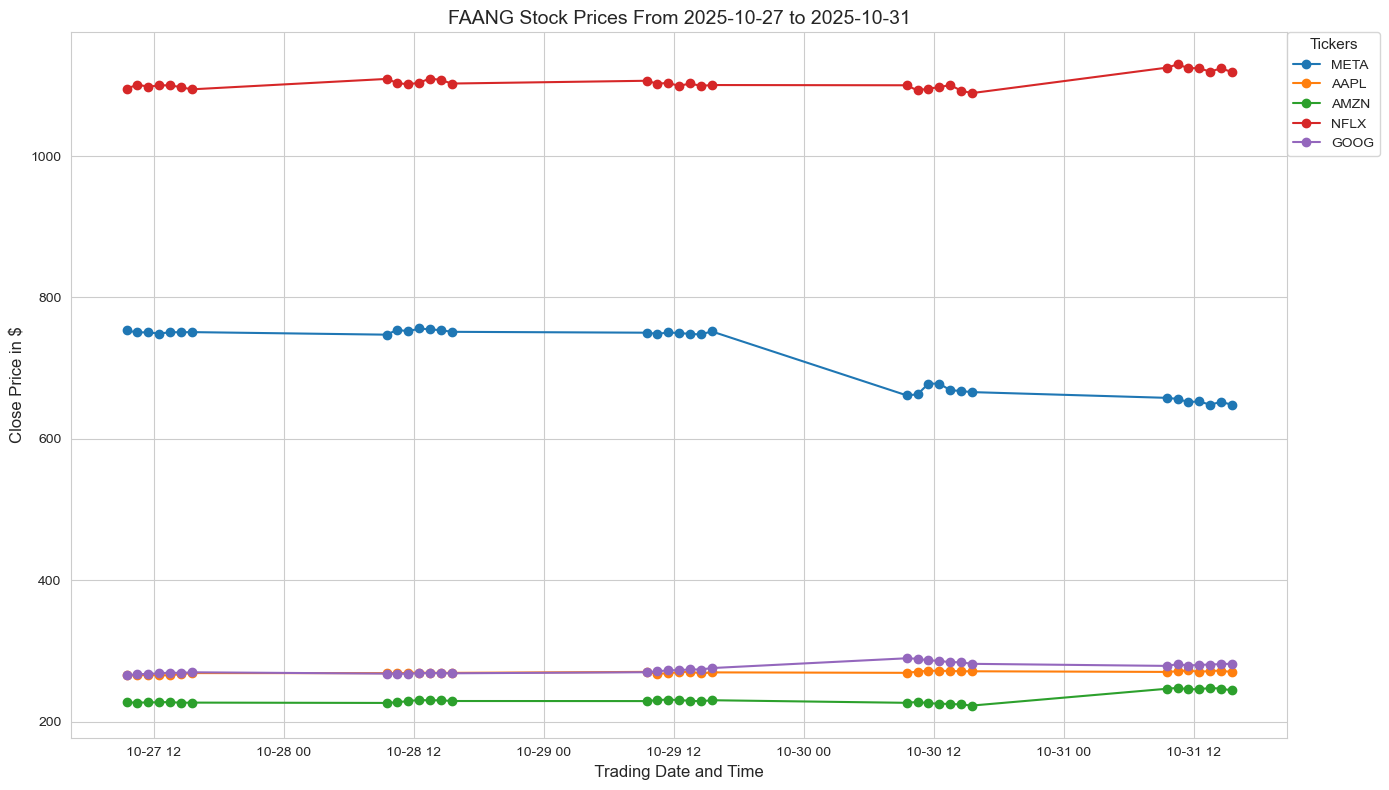

INFO:root:Plot saved to plots\20251102_180146.png


<Figure size 640x480 with 0 Axes>

In [362]:
def plot_data(df_raw, png_file_path):
    """plot_data

    Args:
        df (pd.DataFrame): The data as a pandas DataFrame.
        png_file_path (str): The path to save the plot image.

    Returns:
        None
    """
    # copy dataframe to avoid modifying original
    df = df_raw.copy()
    df['Datetime_EST'] = df.index.tz_convert('US/Eastern')
    df['Date'] = df['Datetime_EST'].dt.date
    start_date = df['Date'].min()
    end_date = df['Date'].max()
    fig, ax = plt.subplots()
    logging.info(f"Data covers from {start_date} to {end_date}")
    # Define tickers globally or pass as parameter
    if df is None or png_file_path is None:
        logging.error("DataFrame or PNG file path is None.")
        return
    #print(date_list)
    fig.set_size_inches(14, 8)
    for ticker in tickers:
        ax.plot(df['Datetime_EST'], df[(ticker, 'Close')], label=ticker, linestyle='-', marker='o')
    ax.set_xlabel(' Trading Date and Time ', fontsize=12)
    ax.set_ylabel('Close Price in $', fontsize=12)
    ax.set_title(f'FAANG Stock Prices From {start_date} to {end_date}', fontsize=14)
    leg = ax.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.get_title().set_fontsize(11)
    leg.set_title('Tickers')
    plt.tight_layout()
    plt.show()
    plt.savefig(png_file_path)
    logging.info(f"Plot saved to {png_file_path}")
plot_data(df, png_file_path)

INFO:root:Data covers from 2025-10-27 to 2025-10-31


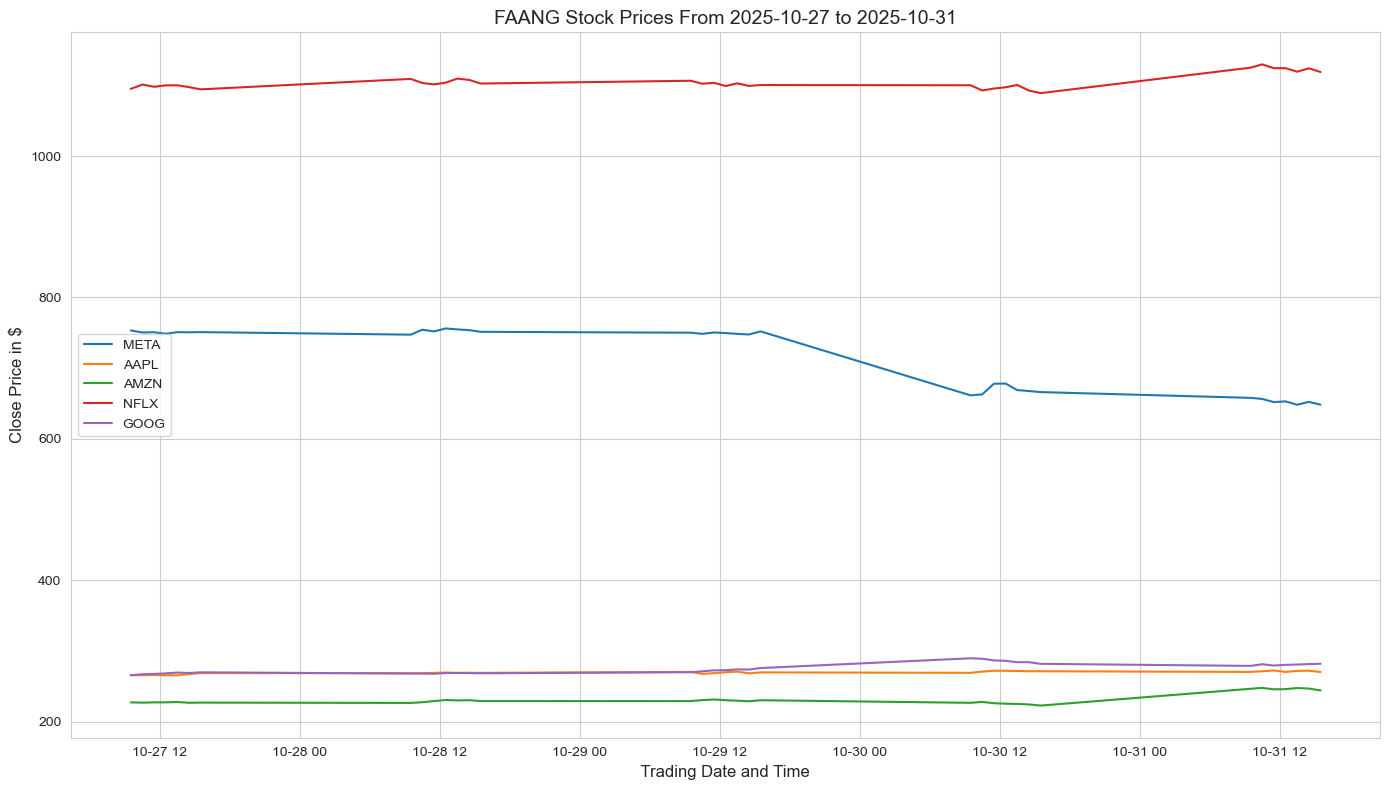

INFO:root:Plot saved to plots\20251102_180146.png


<Figure size 640x480 with 0 Axes>

In [355]:
plot_data(df, png_file_path)
#------------------------------------------------------------------------------


Try alternatives to plotting data 


In [342]:

# Look for latest file
return_code, return_message, latest_csv_filename = get_latest_file()
print("The latest file name is:", latest_csv_filename)
logging.info(f"Loading data from file: {latest_csv_filename}")
# pull the date and timestamp out of file name
filename_only = os.path.basename(latest_csv_filename)  # get filename without path
print("Filename only:", filename_only)
# remove file extension from filename - in this case .csv
filename_no_ext = os.path.splitext(filename_only)[0]
print("Filename without extension:", filename_no_ext)
# create png filename 
filename_png = filename_no_ext + ".png"
print("PNG Filename:", filename_png)
df = load_file_into_dataframe(latest_csv_filename)
df

INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251102_180146.csv
INFO:root:Loading data from file: ./data\20251102_180146.csv
INFO:root:Successfully loaded data from ./data\20251102_180146.csv. Shape: (35, 25)


The latest file name is: ./data\20251102_180146.csv
Filename only: 20251102_180146.csv
Filename without extension: 20251102_180146
PNG Filename: 20251102_180146.png


(0,
 'Success',
 Ticker                           AMZN                                      \
 Price                            Open        High         Low       Close   
 Datetime                                                                    
 2025-10-27 13:30:00+00:00  227.809998  228.399994  226.520004  227.352798   
 2025-10-27 14:30:00+00:00  227.345001  227.451401  226.610703  226.933502   
 2025-10-27 15:30:00+00:00  226.940002  227.940002  226.839996  227.309998   
 2025-10-27 16:30:00+00:00  227.320007  227.889999  227.169998  227.380005   
 2025-10-27 17:30:00+00:00  227.389999  227.964996  227.369995  227.820007   
 2025-10-27 18:30:00+00:00  227.820007  228.000000  225.539993  226.729996   
 2025-10-27 19:30:00+00:00  226.735504  227.520004  226.550003  226.979996   
 2025-10-28 13:30:00+00:00  228.220001  228.589996  226.210007  226.520004   
 2025-10-28 14:30:00+00:00  226.529999  227.880005  226.250000  227.550003   
 2025-10-28 15:30:00+00:00  227.539993  229.2299

In [343]:
print("PNG File Path:", png_file_path)

# Prepare data for seaborn plotting - reshape for long format
plot_data = []
for ticker in tickers:
    ticker_data = pd.DataFrame({
        'Date': df.index,
        'Close': df[(ticker, 'Close')].values,
        'High': df[(ticker, 'High')].values,
        'Low': df[(ticker, 'Low')].values,
        'Ticker': ticker
    })
    plot_data.append(ticker_data)

# Combine all ticker data
combined_data = pd.concat(plot_data, ignore_index=True)

# Create seaborn plot with proper styling
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Plot close prices using seaborn
sns.lineplot(data=combined_data, x='Date', y='Close', hue='Ticker', 
             palette='husl', linewidth=2.5)

# Add shaded areas for high-low ranges
for ticker in tickers:
    ticker_subset = combined_data[combined_data['Ticker'] == ticker]
    plt.fill_between(ticker_subset['Date'], 
                     ticker_subset['High'], 
                     ticker_subset['Low'], 
                     alpha=0.15, 
                     label=f'{ticker} Range')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.title('FAANG Stock Prices with High-Low Range', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig(png_file_path, dpi=300, bbox_inches='tight')

PNG File Path: plots\20251102_180146.png


TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
# Data is already in the right format - combined_data has Date, Close, High, Low, Ticker
# Now normalize the price data to 0-1 range for each ticker individually
normalized_data = combined_data.copy()

# Normalize each ticker separately
for ticker in tickers:
    ticker_mask = normalized_data['Ticker'] == ticker
    for column in ['Close', 'High', 'Low']:
        ticker_values = normalized_data.loc[ticker_mask, column]
        min_val = ticker_values.min()
        max_val = ticker_values.max()
        normalized_data.loc[ticker_mask, column] = (ticker_values - min_val) / (max_val - min_val)

print("Normalized data (first 10 rows):")
print(normalized_data.head(10))

Normalized data (first 10 rows):
                       Date     Close      High       Low Ticker
0 2025-10-22 13:30:00+00:00  0.178647  0.390621  0.232980   META
1 2025-10-22 14:30:00+00:00  0.085004  0.255169  0.185614   META
2 2025-10-22 15:30:00+00:00  0.098481  0.146526  0.142857   META
3 2025-10-22 16:30:00+00:00  0.000000  0.052380  0.027841   META
4 2025-10-22 17:30:00+00:00  0.060736  0.000000  0.000000   META
5 2025-10-22 18:30:00+00:00  0.184521  0.125301  0.148160   META
6 2025-10-22 19:30:00+00:00  0.211818  0.154742  0.272455   META
7 2025-10-23 13:30:00+00:00  0.426054  0.452926  0.313224   META
8 2025-10-23 14:30:00+00:00  0.461990  0.404313  0.455751   META
9 2025-10-23 15:30:00+00:00  0.392192  0.441630  0.453679   META


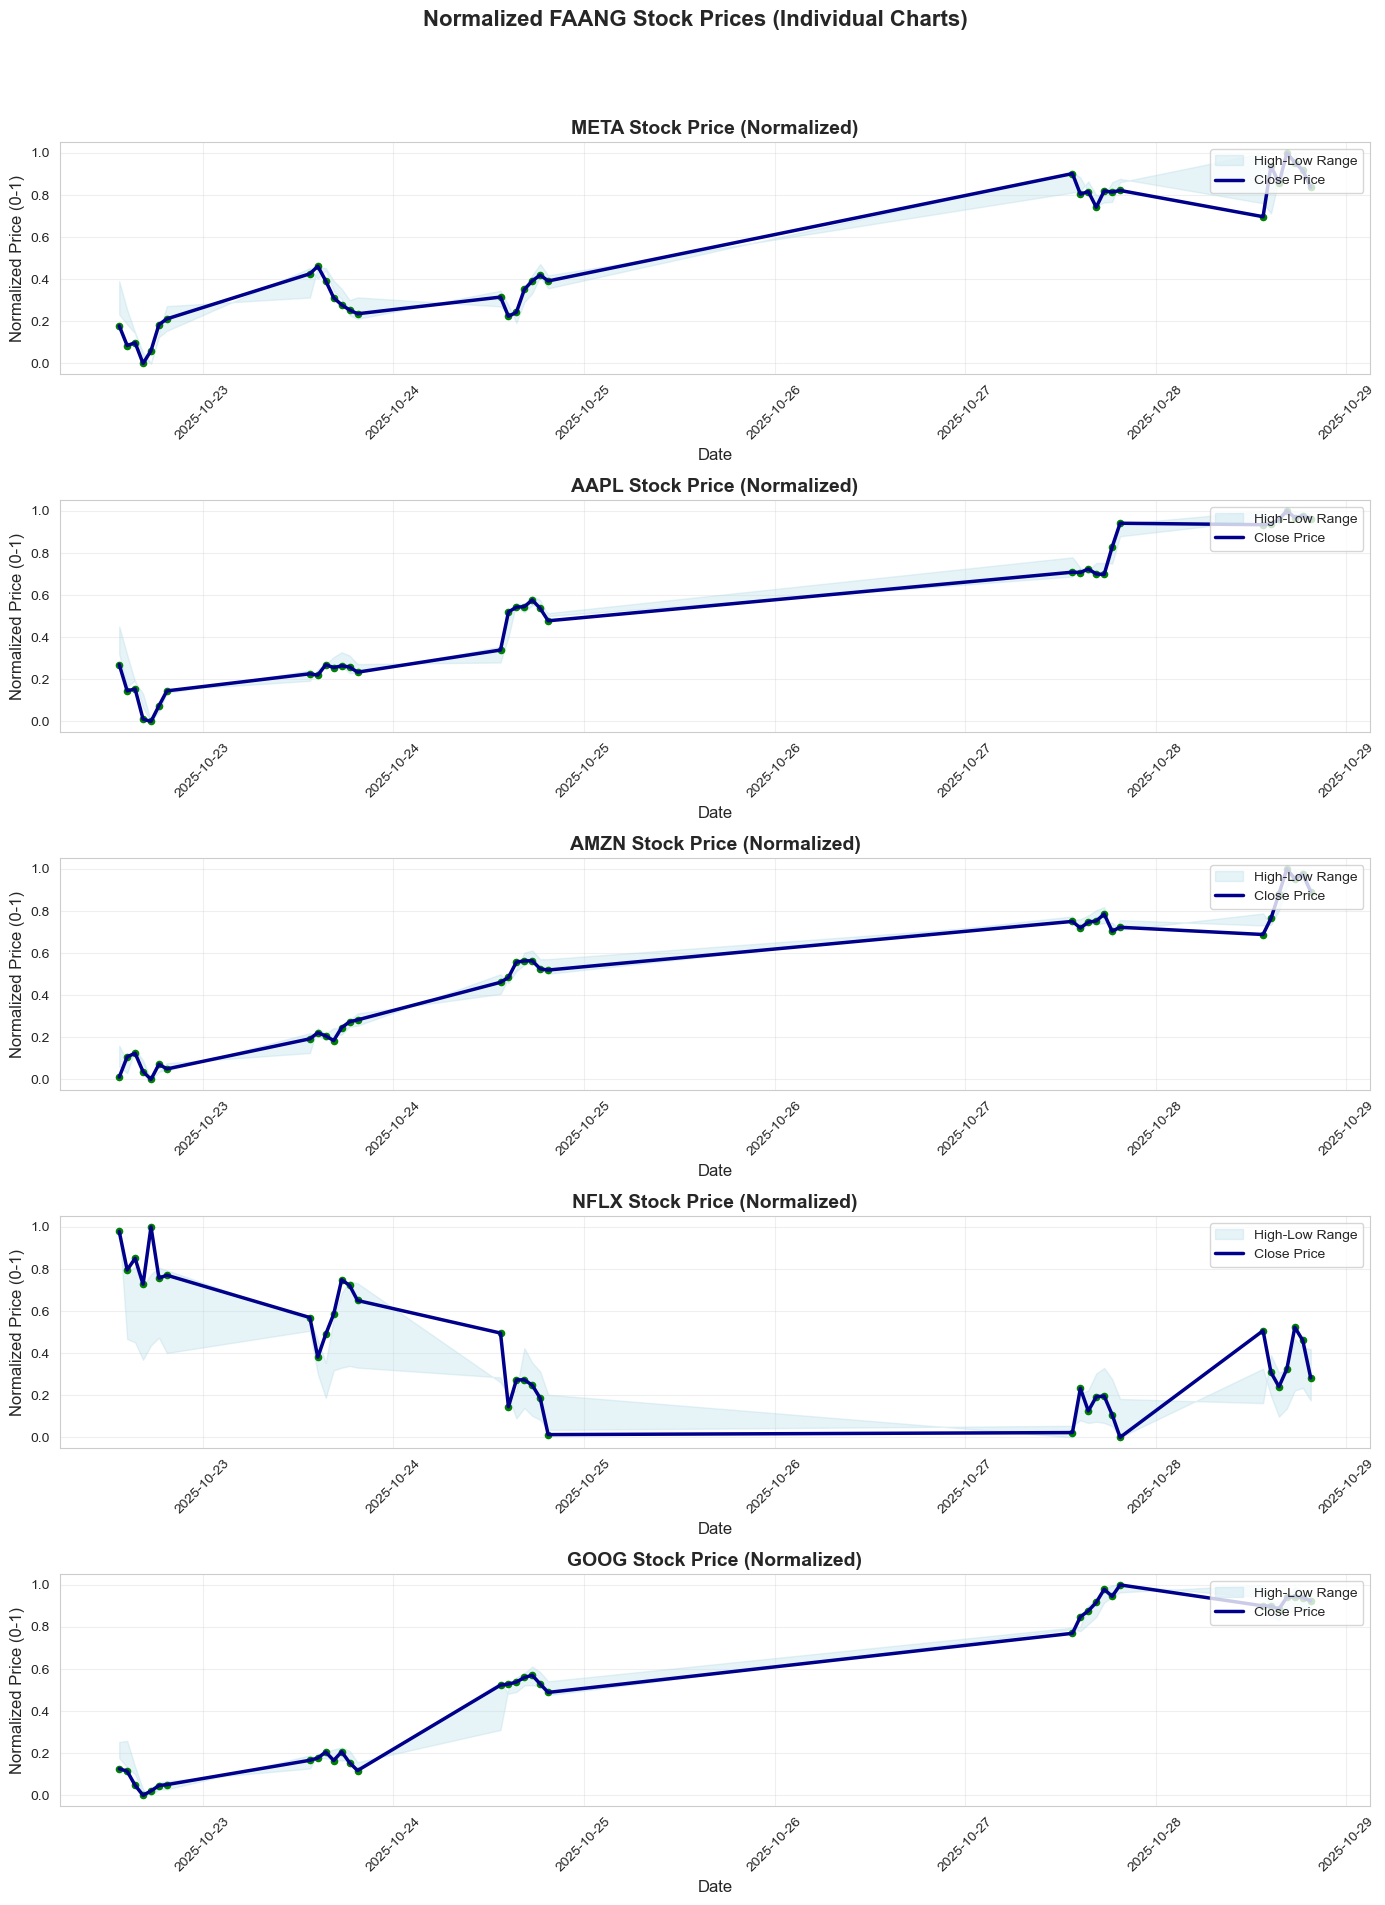

Normalized individual plots saved to: ./data/20251029_213320_normalized_individual.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Create separate plots for each ticker using normalized data
# Note: This was all done using vibe coding using vscode and github copilot
fig, axes = plt.subplots(len(tickers), 1, figsize=(14, 4 * len(tickers)))
fig.suptitle('Normalized FAANG Stock Prices (Individual Charts)', fontsize=16, fontweight='bold', y=0.98)

for i, ticker in enumerate(tickers):
    # Filter data for current ticker
    ticker_data = normalized_data[normalized_data['Ticker'] == ticker].copy()
    ticker_data = ticker_data.sort_values('Date')
    
    ax = axes[i]
    
    # Plot shaded area between high and low
    ax.fill_between(ticker_data['Date'], 
                   ticker_data['High'], 
                   ticker_data['Low'], 
                   alpha=0.3, 
                   color='lightblue',
                   label='High-Low Range')
    
    # Plot close price line
    sns.lineplot(data=ticker_data, x='Date', y='Close', 
                ax=ax, color='darkblue', linewidth=2.5, label='Close Price')
    # Mark each data point with a small circle
    ax.scatter(ticker_data['Date'], ticker_data['Close'], color='green', s=20)
    
    ax.set_title(f'{ticker} Stock Price (Normalized)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Normalized Price (0-1)', fontsize=12)
    ax.legend(loc='upper right')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Save the plot
normalized_png_path = png_file_path.replace('.png', '_normalized_individual.png')
plt.savefig(normalized_png_path, dpi=300, bbox_inches='tight')
print(f"Normalized individual plots saved to: {normalized_png_path}")

__Gemini Prompt__

How do I plot a time series in such a way that that so missing time is not included and the gap between each time series is consistent

The recommendation is too plot against the index , and not the time

IndexError: single positional indexer is out-of-bounds

IndexError: single positional indexer is out-of-bounds

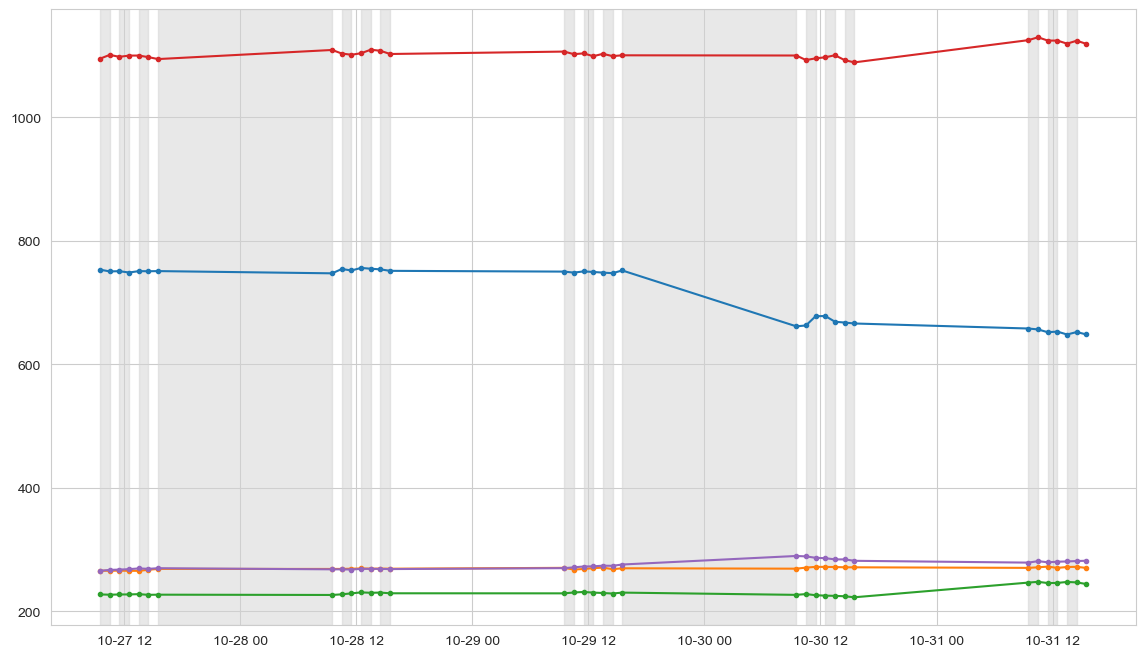

In [ ]:
# Best practice: create a figure and an axis object
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(14, 8))

start_date = df['Date'].min()
end_date = df['Date'].max()

# Plot each ticker's close price
for ticker in tickers:
    ax.plot(
        df['Datetime_EST'],
        df[(ticker, 'Close')],
        label=ticker,
        marker='o',
        markersize=3,
        scalex=True
    )

# Shade every alternate day (light grey)
unique_dates = pd.Series(df['Date']).dropna().sort_values().unique()
for idx, d in enumerate(unique_dates):
    if idx % 2 == 0:
        mask = df['Date'] == d
        day_times = df.loc[mask, 'Datetime_EST']
        if not day_times.empty:
            day_start = day_times.min()
            day_end = day_times.max()
            ax.axvspan(day_start, day_end, color='lightgrey', alpha=0.15, zorder=0)

# Labels and title
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Close Price in Dollars', fontsize=16)
ax.set_title(f'Closing Stock Prices From {start_date} to {end_date}', fontsize=20)

# Date tick formatting
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
fig.autofmt_xdate(rotation=90)

ax.legend()
fig.tight_layout()

# Save before showing
fig.savefig(png_file_path, dpi=150, bbox_inches='tight')
plt.show()
        # get date_ind for x
        date_ind = ticker_data['date_ind'].loc[x]
        # if start of new day , draw vertical line
        if pd.notna(date_ind) and date_ind != 0:
            ax.axvline(x=x, color='red', linestyle='--', linewidth=0.5)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Normalized Price (0-1)', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(ticker_data.index)
    # draw a line per start of each day
    ax.set_xticklabels(ticker_data['Date'].dt.strftime('%y-%m-%d %H:%M'), rotation=45, ha='right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Save the plot
normalized_png_path = png_file_path.replace('.png', '_normalized_individual.png')
plt.savefig(normalized_png_path, dpi=300, bbox_inches='tight')
print(f"Normalized individual plots saved to: {normalized_png_path}")
normalized_data